In [47]:
import glob 
import re
import pandas as pd
import seaborn as sns

def collect_genre(files):
    g = []
    for file in files:
        if 'concat' in file: continue
        try:
            g.append(re.findall(r'\\(.*).flac', file)[0].split('-')[0])
        except:
            g.append(re.findall(r'/(.*).flac', file)[0].split('-')[0])
    return g

gt5 = []
with open('./data/cnceleb_train_gt5.txt', 'r') as f:
    for line in f:
        gt5.append(line)
        

whole = []
with open('./data/cnceleb_train_whole.txt', 'r') as f:
    for line in f:
        whole.append(line)
        

gt5_df = pd.Series(collect_genre(gt5))
whole_df = pd.Series(collect_genre(whole))


In [49]:
gt5_df

0        singing
1        singing
2        singing
3        singing
4        singing
          ...   
41164       play
41165       play
41166       play
41167       play
41168       play
Length: 41169, dtype: object

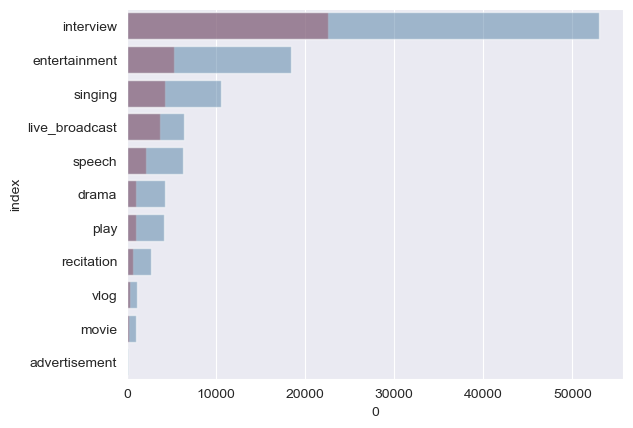

In [50]:
import matplotlib.pyplot as plt 

sns.set_style('darkgrid')

sns.barplot(data = gt5_df.value_counts().reset_index(), y = 'index', x = 0, color = 'red', alpha = 0.5)
sns.barplot(data = whole_df.value_counts().reset_index(), y = 'index', x = 0, color = 'steelblue', alpha = 0.5)
plt.show()



In [5]:
from loader import SimpleDataLoader
import torch 
from utils import Config
SOURCE_LIST = './data/voxceleb_train.txt'
SOURCE_PATH = './data/voxceleb2/'
TARGET_PATH = './data/cnceleb/data/'
TARGET_LIST = './data/cnceleb_train_gt5.txt'

ds = SimpleDataLoader(
    source_list=SOURCE_LIST,
    source_path=SOURCE_PATH,
    target_list=TARGET_LIST,
    target_path=TARGET_PATH,
    augment=True,
    musan_path=Config.MUSAN_PATH,
    rir_path=Config.RIR_PATH,
    max_frames=Config.MAX_FRAMES
)
loader = torch.utils.data.DataLoader(
    ds,
    batch_size=32,
    shuffle=True,
    num_workers=1,
    drop_last=True
)


In [87]:
from torch.utils.data.sampler import Sampler
import numpy as np
from loader.train import get_data_from_file
from loader.utils import load_wav
# 1. define the sampler
# 2. chop the utterances into 1s segments

SOURCE_LIST = './data/voxceleb_train.txt'
SOURCE_PATH = './data/voxceleb2/'
TARGET_PATH = './data/cnceleb/data/'
TARGET_LIST = './data/cnceleb_train_gt5.txt'

rdsegs = 0

class MySampler(Sampler):
    
    def __init__(self, data_source, batch_size, steps) -> None:
        super().__init__(data_source)
        
        self.batch_size = batch_size
        self.steps = steps
        
        self.source_len = len(data_source.source_data)
        if data_source.target_data is not None and data_source.target_path is not None:
            self.target_len = len(data_source.target_data)
        
    def __iter__(self):
        
        indices = []
        for i in range(self.steps):
            num_segs = np.random.randint(1,5, size = (1,))
            source_batch = np.random.randint(0, self.source_len, size = (self.batch_size, ))
            target_batch = np.random.randint(0, self.target_len, size = (self.batch_size, ))
            indices.append(np.concatenate([num_segs, source_batch, target_batch]))
        
        return iter(indices)
    
    def __len__(self):
        return self.steps
    
class MyDs(torch.utils.data.Dataset):
    def __init__(self, source_list, source_path, target_list = None, target_path = None) -> None:
        super().__init__()
        self.source_data, self.source_label = get_data_from_file(
            source_path, source_list)

        self.target_data = None 
        self.target_path = None
        if target_list is not None and target_path is not None:
            self.target_data, self.target_label = get_data_from_file(
                target_path, target_list)
            
            
    def __getitem__(self, indices):
        batch = []
        seg = indices[0]
        bz = indices[1:] // 2
        
        source_batch = []
        source_label = []
        target_batch = []

        for idx in indices[1:bz]:
            source_batch.append(load_wav(self.source_data[idx], max_frames=200, evalmode=False))
            source_label.append(self.source_label[idx])
            
        for idx in indices[bz:]:
            target_batch.append(load_wav(self.target_data[idx], max_frames=200, evalmode=False))
        
        source_batch = np.concatenate(source_batch)
        target_batch = np.concatenate(target_batch)
        source_label = np.concatenate(source_label)
            
        return (torch.FloatTensor(source_batch), torch.FloatTensor(target_batch)), source_label
    
    
ds = MyDs(
    source_list=SOURCE_LIST,
    source_path=SOURCE_PATH,
    target_list=TARGET_LIST,
    target_path=TARGET_PATH,
)
spl = MySampler(
    data_source = ds,
    batch_size = 32,
    steps = 3
)
loader = torch.utils.data.DataLoader(
    ds, 
    sampler = spl,
    )

for data, label in loader:
    source_data = data[0]
    target_data = data[1]
    print(source_data.shape, target_data.shape)
    break
    
    

AttributeError: 'MySampler' object has no attribute 'target_len'

In [35]:
for i in iter([[1,2,3], 999]):
    print(i)

[1, 2, 3]
999
